#Import section

In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
from datasets import load_dataset, Dataset

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import models, transforms
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.optim as optim

from transformers import TrainingArguments, Trainer, AutoImageProcessor, BeitModel

import random

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from google.colab import drive

import zipfile
import os
import shutil
from PIL import Image

drive.mount('/content/drive')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


Mounted at /content/drive


#Data Section

##Transform and Collate

We define two transformations: one for VGG16 and one for the BEiT model

In [ ]:
#VGG16 transform
transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#BEiT transform
beit_image_processor = AutoImageProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")

transform_beit = lambda image: torch.squeeze(beit_image_processor(image, return_tensors="pt")['pixel_values'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

Wrapper class for the transformations is required because we will work on both the image and the label

In [ ]:
class TransformWrapper:
    def __init__(self, transform_vgg, transform_beit):
        self.transform_vgg = transform_vgg
        self.transform_beit = transform_beit

    def __call__(self, image, label):

        # Return a dictionary with image and label
        return {
            'vgg16_image': transform_vgg(image),
            'beit_image': transform_beit(image),
            'label': label
        }

Collate definition

In [ ]:
def collate_fn(batch):
  vgg16_images = torch.stack([item['vgg16_image'] for item in batch])
  beit_images = torch.stack([item['beit_image'] for item in batch])
  labels = torch.tensor([item['label'] for item in batch])
  return {'vgg16_images': vgg16_images, 'beit_images': beit_images, 'labels': labels}

##Load Deepfake Challenge Dataset

This is the dataset used for the training part.
Ref to this [link](https://iplab.dmi.unict.it/deepfakechallenge/) for further details about the dataset.

This is the class that wraps the training dataset. It is similar to the `ImageFolder` class of PyTorch but it is adapted for the folder structure of the training dataset.

In [ ]:
class DeepfakeChallengeDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Recursively read the directory structure and collect image paths and labels
        for label_name in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label_name)
            if os.path.isdir(label_dir):
                for subdir in os.listdir(label_dir):
                    subdir_path = os.path.join(label_dir, subdir)
                    if os.path.isdir(subdir_path):
                        for img_file in os.listdir(subdir_path):
                            if img_file.endswith(('.jpg', '.jpeg', '.png')):
                                img_path = os.path.join(subdir_path, img_file)
                                self.image_paths.append(img_path)
                                self.labels.append(int(label_name))  # Use the folder name as label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        return self.transform(image, label)

    def __getitems__(self, idx):
        result = []
        for i in idx:
            img_path = self.image_paths[i]
            image = Image.open(img_path).convert("RGB")
            label = self.labels[i]

            transformation_result = self.transform(image, label)
            result.append(transformation_result)
        return result



Extract dataset zip file from google drive

In [ ]:
zip_path = 'drive/MyDrive/ComputerVision/datasets/deepfakechallenge/training-task1.zip'
extract_path = 'deepfakechallenge/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Define dataset

In [ ]:
challenge_dataset = DeepfakeChallengeDataset(root_dir=extract_path + 'training-task1', transform=TransformWrapper(transform_vgg, transform_beit))

Print sample

In [ ]:
challenge_dataset[1]

{'vgg16_image': tensor([[[ 0.1216,  0.1373,  0.1373,  ...,  0.5686,  0.5059,  0.2471],
          [ 0.1216,  0.1216,  0.1294,  ...,  0.5686,  0.4667,  0.1373],
          [ 0.1451,  0.1294,  0.1216,  ...,  0.5529,  0.3882,  0.0510],
          ...,
          [-0.2706, -0.4588, -0.4196,  ..., -0.9137, -0.8118, -0.5294],
          [-0.2392, -0.4431, -0.4196,  ..., -0.9216, -0.8118, -0.6078],
          [-0.2157, -0.4431, -0.4353,  ..., -0.9294, -0.8353, -0.6392]],
 
         [[-0.1294, -0.1216, -0.1216,  ...,  0.8824,  0.8275,  0.6235],
          [-0.1137, -0.1059, -0.1137,  ...,  0.8902,  0.7882,  0.5451],
          [-0.1216, -0.1059, -0.1059,  ...,  0.8745,  0.7333,  0.4745],
          ...,
          [-0.3804, -0.5765, -0.5922,  ..., -0.9059, -0.7882, -0.4667],
          [-0.3490, -0.5765, -0.6000,  ..., -0.8980, -0.7882, -0.5451],
          [-0.3333, -0.5765, -0.6078,  ..., -0.9059, -0.7961, -0.5765]],
 
         [[-0.3412, -0.3255, -0.3412,  ...,  0.9216,  0.8745,  0.7333],
          [-0

Split dataset into training and validation `Subset` (80% - 20%)

In [ ]:
# Set the split ratio
dataset_size = len(challenge_dataset)
split_ratio = 0.8
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(challenge_dataset, [train_size, val_size])

training_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, collate_fn=collate_fn)
validation_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##Data analysis

Training Set Class Balance:
  Class  Count
0  Real   7986
1  Fake   4014
Validation Set Class Balance:
  Class  Count
0  Real   2014
1  Fake    986


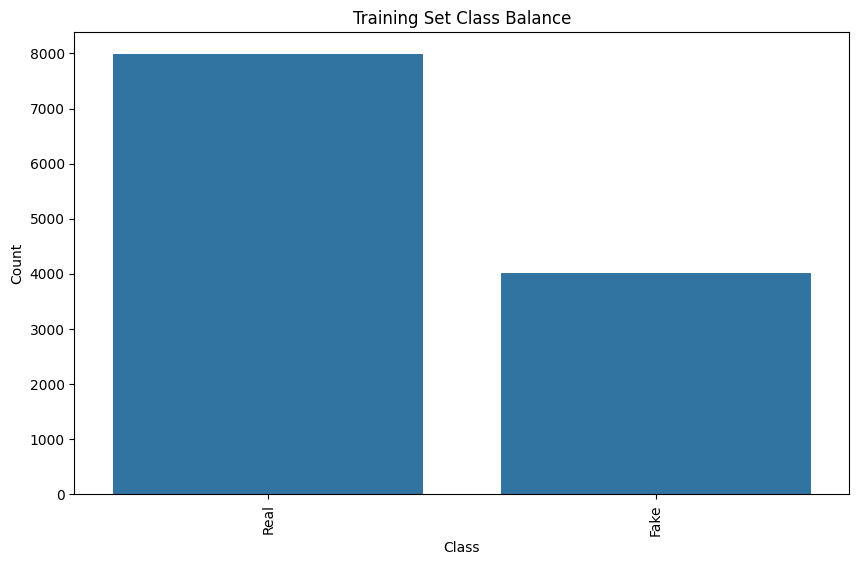

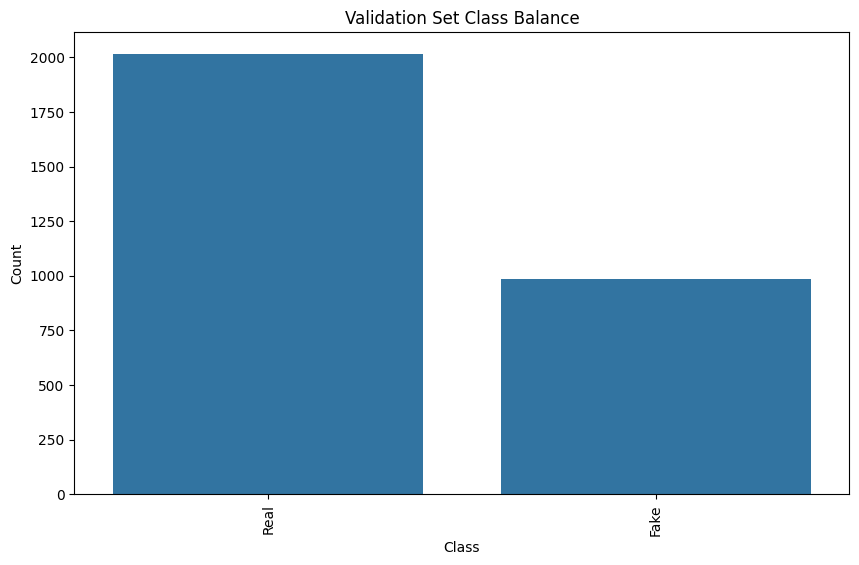

In [ ]:
# Function to analyze class balance
def analyze_class_balance(subset):
    # Extract labels from the subset
    labels = [sample['label'] for sample in subset]

    # Count occurrences of each class
    label_counts = Counter(labels)

    # Map numeric labels to class names
    classes = ['Real', 'Fake']
    counts = list(label_counts.values())

    # Create a DataFrame for visualization
    df = pd.DataFrame({
        'Class': classes,
        'Count': counts
    })

    return df

# Analyze class balance for training and validation sets
train_class_balance = analyze_class_balance(train_dataset)
val_class_balance = analyze_class_balance(val_dataset)

# Print class balance
print("Training Set Class Balance:")
print(train_class_balance)

print("Validation Set Class Balance:")
print(val_class_balance)

# Plot class balance
def plot_class_balance(df, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Count', data=df)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

# Plot class balance
plot_class_balance(train_class_balance, 'Training Set Class Balance')
plot_class_balance(val_class_balance, 'Validation Set Class Balance')

#Model Section

The model to be trained is a binary classifier based on VGG16 and BEiT features.

In [ ]:
class VGG16_Beit(nn.Module):

  def __init__(self, vgg16, beit):
      super(VGG16_Beit, self).__init__()

      #features
      self.vgg16 = vgg16
      self.beit = beit

      #classifier
      input_size = beit.config.hidden_size + vgg16.classifier[-1].out_features
      self.fc1 = nn.Linear(input_size, 256)
      self.fc2 = nn.Linear(256, 2)

  def forward(self, vgg16_images, beit_images):

    #features combination
    vgg16_features = self.vgg16(vgg16_images)
    beit_features = self.beit(beit_images)

    combined_features = torch.cat([vgg16_features, beit_features.pooler_output], dim=1)

    r1 = F.relu(self.fc1(combined_features))

    #classify then
    return self.fc2(r1)

#Training Section

##Model initialization

Freeze VGG16 and BEiT parameters because we want to train only the classifier on top

In [ ]:
beit_model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k")

vgg16 = models.vgg16(pretrained=True)

# Freeze Beit parameters
for param in beit_model.parameters():
    param.requires_grad = False

# Freeze VGG16 parameters
for param in vgg16.parameters():
    param.requires_grad = False

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/368M [00:00<?, ?B/s]

Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth

Model declaration

In [ ]:
vgg16_beit_model = VGG16_Beit(vgg16, beit_model)
vgg16_beit_model.to(device)

VGG16_Beit(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

##Trainer Class

In [ ]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        log_steps: int = 1_000,
        log_level: int = 2
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = nn.CrossEntropyLoss() # loss function good for classification tasks

        self.log_steps = log_steps
        self.log_level = log_level

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> dict[str, list[float]]:
        """
        Args:
            train_dataloader: a DataLoader instance containing the training instances.
            valid_dataloader: a DataLoader instance used to evaluate learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over epochs.
        """
        assert epochs >= 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0

        losses = {
            "train_losses": [],
            "valid_losses": [],
            "valid_acc": [],
        }

        for epoch in range(1, epochs + 1):
            if self.log_level > 0:
                print(' Epoch {:2d}'.format(epoch))

            epoch_loss = 0.0
            self.model.train()


            # for each batch
            for step, batch in enumerate(train_dataloader):

                vgg16_images = batch['vgg16_images']
                beit_images = batch['beit_images']
                labels = batch['labels']

                #data to device
                vgg16_images = vgg16_images.to(device)
                beit_images = beit_images.to(device)
                labels = labels.to(device)

                self.optimizer.zero_grad()

                # We get the predicted logits from the model
                predictions = self.model(vgg16_images, beit_images)

                # The CrossEntropyLoss expects the predictions to be logits, i.e. non-softmaxed scores across
                # the number of classes, and the labels to be a simple tensor of labels.
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.cpu().tolist()

                if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))

            avg_epoch_loss = epoch_loss / len(train_dataloader)

            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss, valid_acc = self.evaluate(valid_dataloader)

            losses["train_losses"].append(avg_epoch_loss)
            losses["valid_losses"].append(valid_loss)
            losses["valid_acc"].append(valid_acc)

            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}, valid acc = {:0.4f}'.format(epoch, valid_loss, valid_acc))

        if self.log_level > 0:
            print('... Done!')

        return losses


    def _compute_acc(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        # logits [B, 2] are the logits outputted by the model's forward()
        # We take the argmax along the second dimension (dim=1), so we get a tensor of shape [B]
        # where each element is 0 if the 0-class had higher logit, 1 otherwise.
        predictions = torch.argmax(logits, dim=1)
        # We can then directly compare each prediction with the labels, as they are both tensors with shape [B].
        # The average of the boolean equality checks between the two is the accuracy of these predictions.
        # For example, if:
        #   predictions = [1, 0, 0, 1, 1]
        #   labels = [1, 0, 1, 1, 1]
        # The comparison is:
        #   (predictions == labels) => [1, 1, 0, 1, 1]
        return torch.mean((predictions == labels).float()).tolist() # type: ignore

    def evaluate(self, valid_dataloader: DataLoader) -> tuple[float, float]:
        """
        Args:
            valid_dataloader: the DataLoader to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataloader.
        """
        valid_loss = 0.0
        valid_acc = 0.0
        # When running in inference mode, it is required to have model.eval() AND .no_grad()
        self.model.eval()
        with torch.no_grad():
            for step, batch in enumerate(valid_dataloader):

                vgg16_images = batch['vgg16_images']
                beit_images = batch['beit_images']
                labels = batch['labels']

                #data to device
                vgg16_images = vgg16_images.to(device)
                beit_images = beit_images.to(device)
                labels = labels.to(device)

                logits = self.model(vgg16_images, beit_images)

                # Same considerations as the training step apply here
                sample_loss = self.loss_function(logits, labels)
                valid_loss += sample_loss.tolist()

                sample_acc = self._compute_acc(logits, labels)
                valid_acc += sample_acc

        return valid_loss / len(valid_dataloader), valid_acc / len(valid_dataloader),

    def predict(self, batch: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: a tensor of indices
        Returns:
            A tuple composed of:
            - the logits of each class, 0 and 1
            - the prediction for each sample in the batch
              0 if the 0-class had higher logit, 1 otherwise
        """
        self.model.eval()
        with torch.no_grad():
            inputs, labels = batch.values()

            #data to device
            inputs = inputs.to(device)

            logits = self.model(inputs) # [B, 2]
            predictions = torch.argmax(logits, -1) # [B, 1] computed on the last dimension of the logits tensor
            return logits, predictions

Trainer definition with Adam optimizer, learning rate of 10e-4 and regularization because the training set is relatively small

In [ ]:
trainer = Trainer(model=vgg16_beit_model,
                  optimizer=optim.Adam(vgg16_beit_model.parameters(), lr=0.0001, weight_decay=1e-4))

Let's train...

In [ ]:
trainer.train(training_dataloader, validation_dataloader, epochs=6)

Training ...
 Epoch  1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


	[E:  1] train loss = 0.5023
  [E:  1] valid loss = 0.4240, valid acc = 0.8206
 Epoch  2
	[E:  2] train loss = 0.4040
  [E:  2] valid loss = 0.3993, valid acc = 0.8221
 Epoch  3
	[E:  3] train loss = 0.3383
  [E:  3] valid loss = 0.3194, valid acc = 0.8808
 Epoch  4
	[E:  4] train loss = 0.3172
  [E:  4] valid loss = 0.2916, valid acc = 0.8884
 Epoch  5
	[E:  5] train loss = 0.2935
  [E:  5] valid loss = 0.2903, valid acc = 0.8878
 Epoch  6
	[E:  6] train loss = 0.2678
  [E:  6] valid loss = 0.2522, valid acc = 0.9044
... Done!


{'train_losses': [0.5022520922282909,
  0.4040441314907784,
  0.3383494167727359,
  0.31717966330495284,
  0.29347575717466945,
  0.2678295927161866],
 'valid_losses': [0.4239998929044034,
  0.39933439962407374,
  0.31943786207665786,
  0.291641207768562,
  0.2903326882960949,
  0.2522124895390044],
 'valid_acc': [0.8205737091125326,
  0.8221409587149925,
  0.8808415658930515,
  0.8884403502687495,
  0.8878229488717749,
  0.9044452892973068]}

Save the model to google drive

In [ ]:
model_save_name = 'classifier0609242212.pt'
path = F"/content/drive/My Drive/{model_save_name}"
torch.save(vgg16_beit_model, path)